In [966]:
import gensim.models
import math
import matplotlib.pyplot as plt
import numpy as np
import os.path
import pandas as pd
import re
import seaborn as sns
import scipy.stats as stats
import shutil

from zipfile import ZipFile
from gensim.models import KeyedVectors
from itertools import groupby  
from statsmodels.stats.multitest import multipletests
from sklearn.metrics import cohen_kappa_score

In [967]:
flatten = lambda l: [item for sublist in l for item in sublist]

# Get the data

In [1146]:
def get_patients_data(path_to_csv, columns=None, dropna=True):
    """
    gets a csv dataset into pandas keeping specified columns and dropping or keeping na's

    :param path_to_csv: str
    :param columns: list of str, columns to keep, None by default (keeps all)
    :param dropna: bool, whether to drop na's, True by default
    :return: pd.DataFrame
    """
    res = pd.read_csv(path_to_csv, index_col=0)
    if columns:
        columns = list(filter(lambda col: col in res, columns))
        if columns:
            res = res[columns]
    if dropna:
        res = res.dropna()
    return res

In [1147]:
csv = "verbal_fluency_schizo.csv"
columns = ['ID', 'sex', 'diagnosis', 'age', 'education', 'TD', 'PANSS_Total', 'PANSS_O', 'PANSS_P', 'PANSS_N', 
           'HDRS', 'Y2RS', 'animals', 'raw', 'cluster_galya', 'cluster_tanya', 'cluster_nastya']
animals = get_patients_data(csv, columns, dropna=False)
animals = animals[~pd.isnull(animals['animals'])]
animals['animals'] = animals['animals'].apply(lambda s: [x.strip() for x in s.strip().split(';')])
animals.head(2)

,sex,diagnosis,age,education,TD,PANSS_Total,PANSS_O,PANSS_P,PANSS_N,HDRS,Y2RS,animals,raw,cluster_galya,cluster_tanya,cluster_nastya
ID,,,,,,,,,,,,,,,,
S5,"1,00","1,00","30,00","16,00","15,00","85,00","42,00","26,00","17,00",NaN,NaN,"[зебра, лев, слон, носорог, жираф, собака, кош...",(0.5) зебра (0.0) лев (0.2) слон (0.0) носорог...,"зебра, лев, слон, носорог, жираф; собака, кошк...","зебра, лев, слон, носорог, жираф; собака; кошк...","зебра, лев, слон, носорог, жираф; собака, кошк..."
S6,"1,00","1,00","36,00","16,00","12,00","83,00","30,00","19,00","34,00",NaN,NaN,"[кошка, собака, корова, коза, койот, слон, жир...",(0.5) кошка (0.0) собака (0.0) корова (0.0) ко...,"кошка, собака, корова, коза; койот; слон, жира...","кошка, собака, корова, коза; койот; слон, жира...","кошка, собака; корова, коза; койот; слон, жира..."


In [1148]:
animals['binary_diagnosis'] = animals['diagnosis'].apply(lambda x: 1 if x == '1,00' or x == '2,00' else 0)

## Data on all patients (including those who did not perform verbal fluency task)

In [1012]:
csv = "All_psych.csv"
columns = ['ID', 'sex', 'diagnosis', 'age', 'education', 'TD', 'PANSS_Total', 'PANSS_O', 'PANSS_P', 'PANSS_N', 
           'HDRS', 'Y2RS']
psych = get_patients_data(csv, columns, dropna=False)
psych.head(2)

,sex,diagnosis,age,education,TD,PANSS_Total,PANSS_O,PANSS_P,PANSS_N
ID,,,,,,,,,
H1,"2,00","0,00","27,00","22,00","4,00","30,00","16,00","7,00","7,00"
H2,"1,00","0,00","36,00","17,00","7,00","35,00","18,00","8,00","9,00"


In [1014]:
for col in ['age', 'sex', 'education', 'TD', 'PANSS_Total', 'PANSS_O', 'PANSS_P', 'PANSS_N', 'diagnosis']:
    psych[col] = psych[col].apply(lambda s: float(s.replace(',', '.')) if type(s) == str else s)

In [1015]:
psych['binary_diagnosis'] = psych['diagnosis'].apply(lambda x: 1 if x == '1,00' or x == '2,00' else 0)

In [815]:
def display_test(df, columns_to_test, target_column, test, nan_policy='omit', stat_name='x'):
    """
    shows a stats test result for a given list of columns with a key column
    
    :param df: pd.DataFrame
    :param columns_to_test: list of str, column names
    :param target_column: str, column name to test all others against
    :param test: func, stats test taking lists as inputs and returning a tuple of float, power and significance
    :param nan_policy: str, argument for the test, optional, default 'omit'
    :patam stat_name: str, the name of the test variable, optional, default 'x'
    
    :return: styled pd.DataFrame with test results
    """
    res = pd.DataFrame(columns=[stat_name, 'p', 'sig'], index=columns_to_test)

    for column in columns_to_test:
        r, p = list(test(df[target_column], df[column], nan_policy=nan_policy))
        res.loc[column] = [r, p, p<0.05]
    reject, pvalscorr = multipletests(res['p'], alpha= 0.05, method='b')[:2]
    res['bonf'], res['bonf_sig'] = pvalscorr, reject
    res = pd.DataFrame([list(res.loc[column]) for column in columns_to_test], columns=[stat_name, 'p', 'sig', 'bonf', 'bonf_sig'], index=columns_to_test)
    return res.sort_values(['p']).style.background_gradient(axis=0, cmap='Reds')

In [816]:
t_test = ['binary_diagnosis', 'sex']
corr_test = ['TD', 'PANSS_Total', 'PANSS_O', 'PANSS_P', 'PANSS_N', 'age', 'education']

In [1021]:
display_test(psych, corr_test, 'binary_diagnosis', lambda x, y, nan_policy: stats.ttest_ind(x, y, nan_policy=nan_policy, equal_var=False), stat_name='t')

,t,p,sig,bonf,bonf_sig
education,-37.0998,1.32327e-32,True,9.26287e-32,True
age,-27.4316,1.47975e-27,True,1.03583e-26,True
PANSS_O,-15.2715,2.76574e-18,True,1.93602e-17,True
PANSS_Total,-14.1119,4.01652e-17,True,2.81156e-16,True
PANSS_P,-14.0067,5.15731e-17,True,3.61012e-16,True
TD,-13.2779,3.02165e-16,True,2.11516e-15,True
PANSS_N,-9.7844,3.60726e-12,True,2.52508e-11,True


In [1036]:
display_test(psych, corr_test, 'sex', lambda x, y, nan_policy: stats.ttest_ind(x, y, nan_policy=nan_policy, equal_var=False), stat_name='t')

,t,p,sig,bonf,bonf_sig
education,-33.5626,4.65099e-32,True,3.25569e-31,True
age,-26.08,6.90419e-27,True,4.83294e-26,True
PANSS_O,-14.4604,1.6435e-17,True,1.15045e-16,True
PANSS_Total,-13.7751,8.87687e-17,True,6.21381e-16,True
PANSS_P,-12.588,1.42503e-15,True,9.97524e-15,True
TD,-11.1945,4.93065e-14,True,3.45146e-13,True
PANSS_N,-9.00997,3.46318e-11,True,2.42423e-10,True


In [1034]:
mask = calculate_pvalues(psych[corr_test]) > 0.01

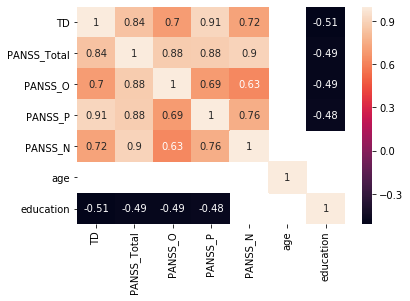

In [1035]:
sns.heatmap(psych[corr_test].corr(), annot=True, mask = mask)
plt.yticks(rotation = 0)
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show() # ta-da!;

## typing

In [1149]:
for col in ['age', 'sex', 'education', 'TD', 'PANSS_Total', 'PANSS_O', 'PANSS_P', 'PANSS_N', 'HDRS', 'Y2RS', 'diagnosis']:
    animals[col] = animals[col].apply(lambda s: float(s.replace(',', '.')) if type(s) == str else s)

In [1150]:
animals.head(2)

,sex,diagnosis,age,education,TD,PANSS_Total,PANSS_O,PANSS_P,PANSS_N,HDRS,Y2RS,animals,raw,cluster_galya,cluster_tanya,cluster_nastya,binary_diagnosis
ID,,,,,,,,,,,,,,,,,
S5,1.0,1.0,30.0,16.0,15.0,85.0,42.0,26.0,17.0,NaN,NaN,"[зебра, лев, слон, носорог, жираф, собака, кош...",(0.5) зебра (0.0) лев (0.2) слон (0.0) носорог...,"зебра, лев, слон, носорог, жираф; собака, кошк...","зебра, лев, слон, носорог, жираф; собака; кошк...","зебра, лев, слон, носорог, жираф; собака, кошк...",1
S6,1.0,1.0,36.0,16.0,12.0,83.0,30.0,19.0,34.0,NaN,NaN,"[кошка, собака, корова, коза, койот, слон, жир...",(0.5) кошка (0.0) собака (0.0) корова (0.0) ко...,"кошка, собака, корова, коза; койот; слон, жира...","кошка, собака, корова, коза; койот; слон, жира...","кошка, собака; корова, коза; койот; слон, жира...",1


## extract timestamps

**TODO: fix pause - word relation, as now we omit words we don't know and suddenly nothing works**

In [1151]:
def get_times(s):
    if type(s) == str:
        s = s.strip()
        s = re.sub('[а-я]+', ' ', s)
        s = s.replace('·', '')
        while '  ' in s:
            s = s.replace('  ', ' ')
        s = s.replace('(', ' ')
        s = s.replace(')', ' ')
        return [float(x) for x in s.split()]
    else:
        s

In [1152]:
animals['raw'] = animals['raw'].apply(lambda s: s.strip() if type(s) == str else s)
animals['times'] = animals['raw'].apply(get_times)

In [1153]:
animals['len_times'] = animals['times'].apply(lambda x: len(x) if type(x) == list else 0)
animals['len_words'] = animals['animals'].apply(lambda x: len(x) if type(x) == list else 0)
animals['diff'] = animals['len_words'] - animals['len_times']
np.unique(animals[animals['len_times'] > 0]['diff'])

array([-1,  0], dtype=int64)

In [1154]:
animals['first_pause'] = animals['times'].apply(lambda l: l[0] if l else l)
animals['last_pause'] = animals['times'].apply(lambda l: l[-1] if l else l)
animals['total_pause'] = animals['times'].apply(lambda l: sum(l) if l else l)
animals['times'] = animals['times'].apply(lambda l: l[1:-1] if l else l)

## UNIQUE word num

In [1155]:
animals['unique_num'] = animals['animals'].apply(lambda x: len(set(x)) if type(x) == list else 0)

## repetitions number

In [1156]:
animals['repeat_num'] = animals['len_words'] - animals['unique_num']

## omit immediate repetitions from EVERYTHING

In [1157]:
def omit_repeat(words):
    """
    removes immediate repetitions for a list of str
    
    :param words: list of str
    :return: list of str with immediate repetitions removed
    """
    return [i[0] for i in groupby(words)]

In [1158]:
animals['animals'] = animals['animals'].apply(omit_repeat)

In [1159]:
animals = animals[~pd.isnull(animals['PANSS_Total'])]

# Descriptive statistics

In [1160]:
animals.groupby('binary_diagnosis')[['age', 'education', 'TD', 'PANSS_Total', 'PANSS_O', 'PANSS_P', 'PANSS_N', 'HDRS', 'Y2RS']].apply(np.mean)

,age,education,TD,PANSS_Total,PANSS_O,PANSS_P,PANSS_N,HDRS,Y2RS
binary_diagnosis,,,,,,,,,
0,24.095238,15.904762,5.095238,31.904762,16.523810,7.809524,7.666667,NaN,NaN
1,28.459333,13.333333,11.266667,69.800000,30.533333,17.133333,22.133333,27.0,18.0


In [1161]:
animals.groupby('binary_diagnosis')[['age', 'education', 'TD', 'PANSS_Total', 'PANSS_O', 'PANSS_P', 'PANSS_N', 'HDRS', 'Y2RS']].apply(np.std)

,age,education,TD,PANSS_Total,PANSS_O,PANSS_P,PANSS_N,HDRS,Y2RS
binary_diagnosis,,,,,,,,,
0,4.374218,2.113556,1.508855,2.467016,1.051939,1.005653,1.083791,NaN,NaN
1,7.411016,2.270585,3.315955,15.904716,9.992442,4.410089,8.950729,13.140269,3.0


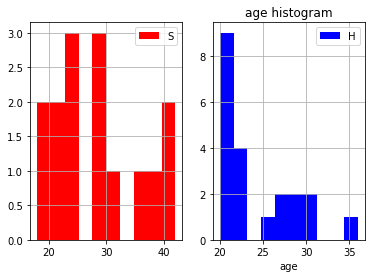

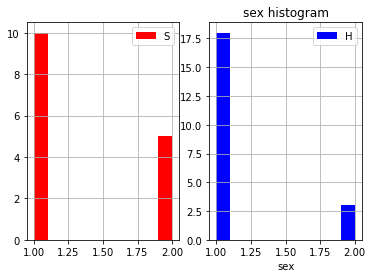

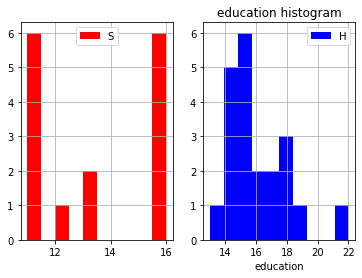

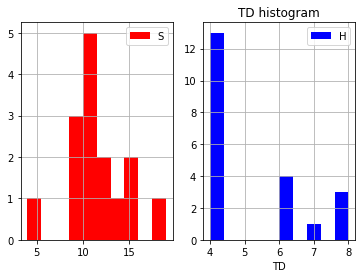

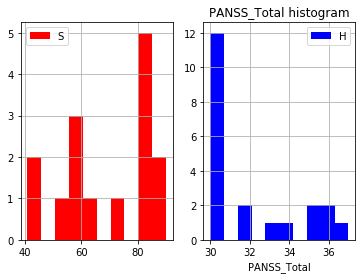

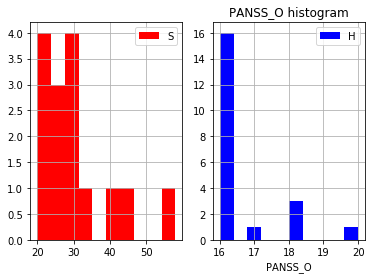

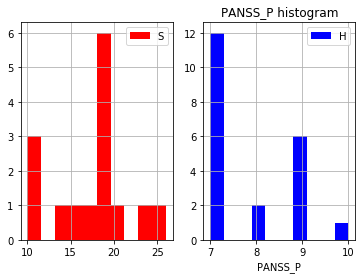

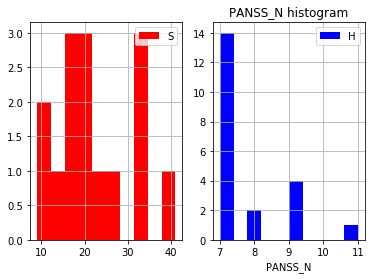

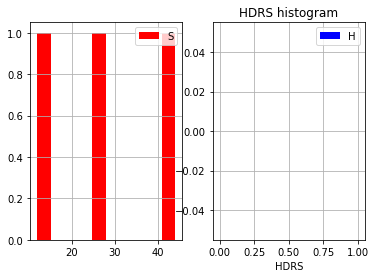

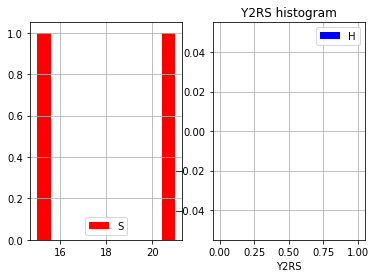

In [1162]:
for col in ['age', 'sex', 'education', 'TD', 'PANSS_Total', 'PANSS_O', 'PANSS_P', 'PANSS_N', 'HDRS', 'Y2RS']:
#     animals.groupby('binary_diagnosis').plot(y=col, kind='hist', legend=True)
    ax1 = plt.subplot(1, 2, 1)
    ax2 = plt.subplot(1, 2, 2)
    animals[animals['binary_diagnosis'] == 1][col].hist(ax=ax1, color='red', label='S')
    animals[animals['binary_diagnosis'] == 0][col].hist(ax=ax2, color='blue', label='H')
    ax1.legend(loc='best')
    ax2.legend(loc='best')
    plt.xlabel(col)
    plt.title(f'{col} histogram')
    plt.show();

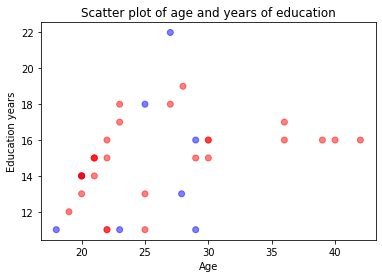

In [1163]:
plt.scatter(animals['age'], animals['education'], 
            c=['red' if x == 1.0 else 'blue' for x in animals['sex']], alpha=0.5)
plt.ylabel('Education years')
plt.xlabel('Age')
plt.title('Scatter plot of age and years of education');

In [1164]:
animals['sex'].value_counts()

1.0    28
2.0     8
Name: sex, dtype: int64

In [1165]:
animals.groupby(['binary_diagnosis'])['sex'].value_counts()

binary_diagnosis  sex
0                 1.0    18
                  2.0     3
1                 1.0    10
                  2.0     5
Name: sex, dtype: int64

In [1166]:
animals[~pd.isnull(animals['PANSS_Total'])].groupby(['binary_diagnosis'])['sex'].value_counts()

binary_diagnosis  sex
0                 1.0    18
                  2.0     3
1                 1.0    10
                  2.0     5
Name: sex, dtype: int64

In [1167]:
animals[~pd.isnull(animals['PANSS_Total'])].groupby(['binary_diagnosis'])['age'].apply(np.mean)

binary_diagnosis
0    24.095238
1    28.459333
Name: age, dtype: float64

In [1169]:
animals.groupby(['binary_diagnosis'])['sex'].value_counts(normalize=True)

binary_diagnosis  sex
0                 1.0    0.857143
                  2.0    0.142857
1                 1.0    0.666667
                  2.0    0.333333
Name: sex, dtype: float64

In [1170]:
animals['diagnosis'].value_counts()

0.0    16
1.0    10
3.0     5
2.0     5
Name: diagnosis, dtype: int64

**let us chect the normality**

In [1171]:
animals[['age', 'education', 'TD', 'PANSS_Total', 'PANSS_O', 'PANSS_P', 'PANSS_N']].apply(lambda l: stats.normaltest(l, nan_policy='omit')[1])

age            0.027187
education      0.493130
TD             0.045804
PANSS_Total    0.032625
PANSS_O        0.000001
PANSS_P        0.046061
PANSS_N        0.001176
dtype: float64

**ok, most of it is definetiley not normally distributed, and we have seen that**<br>
- age
- TD
- PANSS

oh, well, let us use non-parametric correlations, like Spermans

In [1172]:
stats.spearmanr(animals['age'], animals['education'], nan_policy='omit')

SpearmanrResult(correlation=0.496323514867812, pvalue=0.0020789192674083644)

In [1173]:
for col_name in t_test:
    print(col_name)
    display(display_test(animals, corr_test, col_name, lambda x, y, nan_policy: stats.ttest_ind(x, y, nan_policy=nan_policy, equal_var=False), stat_name='t'))

binary_diagnosis


,t,p,sig,bonf,bonf_sig
education,-33.1887,1.70096e-29,True,1.19067e-28,True
age,-24.1794,1.29135e-23,True,9.03948e-23,True
PANSS_O,-13.6699,1.21443e-15,True,8.50101e-15,True
PANSS_Total,-13.0662,4.964e-15,True,3.4748e-14,True
PANSS_P,-12.1679,3.08402e-14,True,2.15881e-13,True
TD,-10.9263,5.29503e-13,True,3.70652e-12,True
PANSS_N,-8.51132,4.59482e-10,True,3.21637e-09,True


sex


,t,p,sig,bonf,bonf_sig
education,-31.5021,2.83833e-28,True,1.98683e-27,True
age,-23.4367,4.13006e-23,True,2.89104e-22,True
PANSS_O,-13.1732,3.72831e-15,True,2.60981e-14,True
PANSS_Total,-12.8445,8.21483e-15,True,5.75038e-14,True
PANSS_P,-11.312,2.61756e-13,True,1.83229e-12,True
TD,-9.7345,1.34614e-11,True,9.42299e-11,True
PANSS_N,-7.99824,2.00629e-09,True,1.40441e-08,True


In [1174]:
animals[corr_test].corr()

,TD,PANSS_Total,PANSS_O,PANSS_P,PANSS_N,age,education
TD,1.000000,0.853004,0.692886,0.919926,0.716932,0.075529,-0.492079
PANSS_Total,0.853004,1.000000,0.876144,0.895015,0.885695,0.224122,-0.444563
PANSS_O,0.692886,0.876144,1.000000,0.701472,0.585689,0.085300,-0.420177
PANSS_P,0.919926,0.895015,0.701472,1.000000,0.760901,0.142536,-0.479652
PANSS_N,0.716932,0.885695,0.585689,0.760901,1.000000,0.343432,-0.315296
age,0.075529,0.224122,0.085300,0.142536,0.343432,1.000000,0.367837
education,-0.492079,-0.444563,-0.420177,-0.479652,-0.315296,0.367837,1.000000


In [1175]:
def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(stats.pearsonr(df[r], df[c])[1], 4)
    return pvalues

In [1176]:
mask = calculate_pvalues(animals[corr_test]) > 0.05 

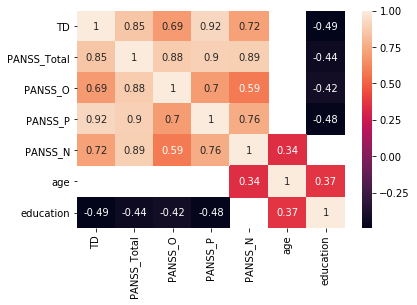

In [1177]:
sns.heatmap(animals[corr_test].corr(), annot=True, mask = mask)
plt.yticks(rotation = 0)
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show() # ta-da!;

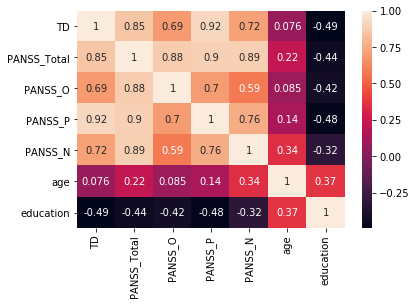

In [1178]:
sns.heatmap(animals[corr_test].corr(), annot=True)
plt.yticks(rotation = 0)
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show() # ta-da!;

# Cosine similarity

## load model

In [1076]:
wv = KeyedVectors.load('models/187/model.model')

how do we handle multiword vectors

In [1077]:
def collocation_handler(model, word, collocation_function=None):
    """
    gets a vector of a word or a bigram using a function to combine two vectors in a colloctaion
    
    :param model: gensim.Word2Vec model
    :param word: str, word or bi-gram
    :param collocation_function: function to combine two word vectors, None by default (np.mean is used)
    :return word_vector: np.ndarray, word vector
    :return not_found: int, number of words that were absent in the model
    """
    not_found = 0
    if ' ' in word:
        if not collocation_function:
            collocation_function = lambda vecs: np.mean(vecs, axis=0)
        words = word.split()
        vecs = []
        not_found = 0
        for word in words:
            if word in model:
                vecs.append(model[word])
            else:
                not_found += 1
        if len(vecs) == 0:
            word_vector = None
        elif len(vecs) == 1:
            word_vector = vecs[0]
        else:
            word_vector = collocation_function(vecs)
    else:
        if word in model:
            word_vector = model[word]
        else:
            word_vector = None
            not_found = 1
    return word_vector, not_found

In [1078]:
no_pos_oov_list = []

In [1079]:
def cos_sim(v1, v2):
    return np.inner(v1, v2)/(np.linalg.norm(v1)*np.linalg.norm(v2))

In [1080]:
def get_cos_sim_list(model, patient_word_list, oov_list, collocation_function=None, oov=True):
    """
    calculates pairwise cosine similarities of words or collocations in a word list

    cosine similarity for a word pair that has a collocation is calculated as
    cosine similarity between a word vector and an average of word vectors from the collocation

    :param model: gensim.word2vec model
    :param patient_word_list: list of strings, words produced by the patient
    :param oov_list: list of str, where to add oov
    :param collocation_function: function combining two word vectors in a collocation, optional default is mean
    :param oov: bool, optional (True by deafult), whether to add oov words to a global variable oov_list
    :return patient_cos_sim_list: list of float, pairwise cosine similarities
    :return not_found: int, number of words missing from the model vocabulary
    """
    patient_cos_sim_list = []
    not_found = 0
    for j, word in enumerate(patient_word_list):
        if j > 0:
            previous_word = patient_word_list[j - 1]
            word_vector, nf = collocation_handler(model, word, collocation_function)
            not_found += nf
            previous_word_vector, nf = collocation_handler(model, previous_word, collocation_function)
            not_found += nf
            if word_vector is None:
                if oov:
                    oov_list.append(word)
                else:
                    continue
            elif previous_word_vector is not None:
                patient_cos_sim_list.append(cos_sim(word_vector, previous_word_vector))
            else:
                continue
    not_found = math.ceil(not_found / 2)
    return patient_cos_sim_list, not_found

## cosine similarities of a list of words

In [1179]:
animals['no_pos_cos_sim_list'], _ = zip(*animals['animals'].map(lambda x: get_cos_sim_list(wv, x, no_pos_oov_list)))
animals.head(2)

,sex,diagnosis,age,education,TD,PANSS_Total,PANSS_O,PANSS_P,PANSS_N,HDRS,...,times,len_times,len_words,diff,first_pause,last_pause,total_pause,unique_num,repeat_num,no_pos_cos_sim_list
ID,,,,,,,,,,,,,,,,,,,,,
S5,1.0,1.0,30.0,16.0,15.0,85.0,42.0,26.0,17.0,NaN,...,"[0.0, 0.2, 0.0, 0.0, 0.4, 0.0, 0.3, 2.0, 1.1, ...",26,26,0,0.5,9.8,44.1,22,4,"[0.38942677, 0.55030197, 0.64486176, 0.5717586..."
S6,1.0,1.0,36.0,16.0,12.0,83.0,30.0,19.0,34.0,NaN,...,"[0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 3.1, 0.0, 2.1, ...",34,33,-1,0.5,0.0,51.9,32,1,"[0.7448462, 0.49169788, 0.8418285, 0.42426452,..."


# Cosine similrity metrics

In [1180]:
animals['no_pos_mean_cos_sim'] = animals['no_pos_cos_sim_list'].apply(np.mean)
animals['no_pos_min_cos_sim'] = animals['no_pos_cos_sim_list'].apply(np.min)
animals['no_pos_max_cos_sim'] = animals['no_pos_cos_sim_list'].apply(np.max)
animals.head(2)

,sex,diagnosis,age,education,TD,PANSS_Total,PANSS_O,PANSS_P,PANSS_N,HDRS,...,diff,first_pause,last_pause,total_pause,unique_num,repeat_num,no_pos_cos_sim_list,no_pos_mean_cos_sim,no_pos_min_cos_sim,no_pos_max_cos_sim
ID,,,,,,,,,,,,,,,,,,,,,
S5,1.0,1.0,30.0,16.0,15.0,85.0,42.0,26.0,17.0,NaN,...,0,0.5,9.8,44.1,22,4,"[0.38942677, 0.55030197, 0.64486176, 0.5717586...",0.524619,0.161768,0.744846
S6,1.0,1.0,36.0,16.0,12.0,83.0,30.0,19.0,34.0,NaN,...,-1,0.5,0.0,51.9,32,1,"[0.7448462, 0.49169788, 0.8418285, 0.42426452,...",0.524889,0.229103,0.841829


# Clustering

## threshold cutoff
cluster boundary
- median & 25th percentile in the whole dataset
- average cosine similarity of each participant


In [1181]:
def threshold_cutoff(list_of_values, threshold):
    """
    finds ids of elements below a threshold and the number of them (+1)
    
    :param list_of_values: list of int or float
    :param threshold: int or float, value that elements must exceed
    :return ids: list of int, ids where value in list_of_values is below threshold
    :return cluster_num: int, number of values below threshold + 1
    """
    if type(list_of_values) != np.ndarray:
        list_of_values = np.array(list_of_values)
    ids = list(np.where(list_of_values < threshold)[0])
    cluster_num = len(ids) + 1
    return ids, cluster_num

### sharp change
cluster boudary - cosine similarity is half _(or some other factor!)_ the average distance in the current cluster

In [1182]:
def sharp_change(list_of_values, factor):
    """
    finds ids of elements below a threshold and the number of them (+1)
    
    :param list_of_values: list of int or float
    :param factor: int or float, nonzero, sharpness of change
    :return ids: list of int, ids where value in list_of_values changes sharply 
                            (by a factor of factor param)
    :return cluster_num: int, number of sharp changes + 1
    """
    cluster = [list_of_values[0]]
    ids = []
    for i, value in enumerate(list_of_values):
        current_mean = np.mean(cluster)
        if value < current_mean/factor:
            ids.append(i)
            cluster = [value]
        else:
            cluster.append(value)
    cluster_num = len(ids) + 1
    return ids, cluster_num

## Apply

In [1183]:
no_pos_list_cos_sim_all = flatten(animals['no_pos_cos_sim_list'].tolist())
no_pos_median = np.median(no_pos_list_cos_sim_all)
no_pos_p25 = np.percentile(no_pos_list_cos_sim_all, 25)
no_pos_p75 = np.percentile(no_pos_list_cos_sim_all, 75)
no_pos_mean = np.mean(no_pos_list_cos_sim_all)
print(f'mean: {no_pos_mean}\n\n25th percentile: {no_pos_p25}\nmedian: {no_pos_median}\n75th percentile: {no_pos_p75}')

mean: 0.4738154709339142

25th percentile: 0.3474675714969635
median: 0.46508556604385376
75th percentile: 0.6214146018028259


In [1184]:
animals['no_pos_c_cut_median'] = animals['no_pos_cos_sim_list'].apply(lambda l: threshold_cutoff(l, no_pos_median)[1])
animals['no_pos_c_cut_mean'] = animals['no_pos_cos_sim_list'].apply(lambda l: threshold_cutoff(l, no_pos_mean)[1])
animals['no_pos_c_cut_p25'] = animals['no_pos_cos_sim_list'].apply(lambda l: threshold_cutoff(l, no_pos_p25)[1])
animals['no_pos_c_cut_mean_local'] = animals['no_pos_cos_sim_list'].apply(lambda l: threshold_cutoff(l, np.mean(l))[1])
animals['no_pos_c_sharp_1.05'] = animals['no_pos_cos_sim_list'].apply(lambda l: sharp_change(l, 1.05)[1])
animals['no_pos_c_sharp_1.005'] = animals['no_pos_cos_sim_list'].apply(lambda l: sharp_change(l, 1.005)[1])
animals['no_pos_c_sharp_1.00001'] = animals['no_pos_cos_sim_list'].apply(lambda l: sharp_change(l, 1.00001)[1])
animals['no_pos_c_sharp_0.95'] = animals['no_pos_cos_sim_list'].apply(lambda l: sharp_change(l, 0.95)[1])
animals['no_pos_c_sharp_0.8'] = animals['no_pos_cos_sim_list'].apply(lambda l: sharp_change(l, 0.8)[1])
animals['no_pos_c_sharp_0.5'] = animals['no_pos_cos_sim_list'].apply(lambda l: sharp_change(l, 0.5)[1])
animals.head(2)

,sex,diagnosis,age,education,TD,PANSS_Total,PANSS_O,PANSS_P,PANSS_N,HDRS,...,no_pos_c_cut_median,no_pos_c_cut_mean,no_pos_c_cut_p25,no_pos_c_cut_mean_local,no_pos_c_sharp_1.05,no_pos_c_sharp_1.005,no_pos_c_sharp_1.00001,no_pos_c_sharp_0.95,no_pos_c_sharp_0.8,no_pos_c_sharp_0.5
ID,,,,,,,,,,,,,,,,,,,,,
S5,1.0,1.0,30.0,16.0,15.0,85.0,42.0,26.0,17.0,NaN,...,9,9,4,13,7,8,8,11,16,24
S6,1.0,1.0,36.0,16.0,12.0,83.0,30.0,19.0,34.0,NaN,...,13,13,6,17,7,7,7,12,17,32


## Means

In [1185]:
methods = ['c_cut_median', 'c_cut_mean', 'c_cut_p25', 'c_cut_mean_local', 
           'c_sharp_1.05', 'c_sharp_1.005', 'c_sharp_1.00001', 
           'c_sharp_0.95', 'c_sharp_0.8', 'c_sharp_0.5']
no_pos_methods = ['no_pos_' + el for el in methods]
animals.groupby(['binary_diagnosis'])[no_pos_methods].apply(np.mean)

,no_pos_c_cut_median,no_pos_c_cut_mean,no_pos_c_cut_p25,no_pos_c_cut_mean_local,no_pos_c_sharp_1.05,no_pos_c_sharp_1.005,no_pos_c_sharp_1.00001,no_pos_c_sharp_0.95,no_pos_c_sharp_0.8,no_pos_c_sharp_0.5
binary_diagnosis,,,,,,,,,,
0,14.238095,14.571429,7.666667,14.428571,9.380952,10.190476,10.238095,12.571429,17.047619,25.571429
1,10.333333,10.533333,5.600000,10.333333,6.666667,7.000000,7.000000,9.000000,11.533333,17.066667


In [1090]:
animals.groupby(['binary_diagnosis'])[no_pos_methods].apply(np.std)

,no_pos_c_cut_median,no_pos_c_cut_mean,no_pos_c_cut_p25,no_pos_c_cut_mean_local,no_pos_c_sharp_1.05,no_pos_c_sharp_1.005,no_pos_c_sharp_1.00001,no_pos_c_sharp_0.95,no_pos_c_sharp_0.8,no_pos_c_sharp_0.5
binary_diagnosis,,,,,,,,,,
0,5.615948,5.611980,3.255374,4.544721,3.016846,3.121580,3.129065,3.492091,5.053600,7.328647
1,4.147288,4.112852,2.602563,3.476908,1.988858,2.250926,2.250926,2.633122,4.112852,7.084882


In [1186]:
for d in [0, 1]:
    print(d)
    print(animals[animals['binary_diagnosis'] == d][no_pos_methods].apply(lambda l: stats.normaltest(l, nan_policy='omit').pvalue))

0
no_pos_c_cut_median        0.299522
no_pos_c_cut_mean          0.223938
no_pos_c_cut_p25           0.001715
no_pos_c_cut_mean_local    0.334811
no_pos_c_sharp_1.05        0.685418
no_pos_c_sharp_1.005       0.623503
no_pos_c_sharp_1.00001     0.678618
no_pos_c_sharp_0.95        0.040727
no_pos_c_sharp_0.8         0.441345
no_pos_c_sharp_0.5         0.405506
dtype: float64
1
no_pos_c_cut_median        0.589303
no_pos_c_cut_mean          0.572734
no_pos_c_cut_p25           0.609018
no_pos_c_cut_mean_local    0.856556
no_pos_c_sharp_1.05        0.710224
no_pos_c_sharp_1.005       0.811859
no_pos_c_sharp_1.00001     0.811859
no_pos_c_sharp_0.95        0.570747
no_pos_c_sharp_0.8         0.551912
no_pos_c_sharp_0.5         0.971609
dtype: float64


## Apply tests

In [1144]:
for col_name in t_test:
    print(col_name)
    display(display_test(animals, no_pos_methods, col_name, lambda x, y, nan_policy: stats.ttest_ind(x, y, nan_policy=nan_policy, equal_var=False), stat_name='t'))

binary_diagnosis


,t,p,sig,bonf,bonf_sig
no_pos_c_sharp_0.95,-25.7504,2.25348e-41,True,2.25348e-40,True
no_pos_c_sharp_0.8,-23.6557,2.2175e-38,True,2.2175e-37,True
no_pos_c_sharp_1.00001,-22.6205,2.08952e-37,True,2.08952e-36,True
no_pos_c_sharp_1.005,-22.5749,2.39571e-37,True,2.39571e-36,True
no_pos_c_sharp_0.5,-22.791,4.27227e-37,True,4.27227e-36,True
no_pos_c_sharp_1.05,-21.3942,9.67774e-36,True,9.67774e-35,True
no_pos_c_cut_mean_local,-21.6259,1.09254e-35,True,1.09254e-34,True
no_pos_c_cut_median,-17.5842,1.58109e-29,True,1.58109e-28,True
no_pos_c_cut_mean,-17.2194,6.12389e-29,True,6.12389e-28,True
no_pos_c_cut_p25,-16.0397,3.24555e-27,True,3.24555e-26,True


sex


,t,p,sig,bonf,bonf_sig
no_pos_c_sharp_0.95,-22.5401,1.91422e-37,True,1.91422e-36,True
no_pos_c_sharp_0.8,-21.4815,1.52479e-35,True,1.52479e-34,True
no_pos_c_sharp_0.5,-21.3241,3.92299e-35,True,3.92299e-34,True
no_pos_c_sharp_1.00001,-19.0305,2.04396e-32,True,2.04396e-31,True
no_pos_c_sharp_1.005,-18.9749,2.47639e-32,True,2.47639e-31,True
no_pos_c_cut_mean_local,-19.1598,3.31408e-32,True,3.31408e-31,True
no_pos_c_sharp_1.05,-17.6212,3.25139e-30,True,3.25139e-29,True
no_pos_c_cut_median,-15.588,2.77818e-26,True,2.77818e-25,True
no_pos_c_cut_mean,-15.2211,1.1964e-25,True,1.1964e-24,True
no_pos_c_cut_p25,-12.6497,3.22089e-21,True,3.22089e-20,True


In [1093]:
for col_name in corr_test:
    print(col_name)
    display(display_test(animals, no_pos_methods, col_name, stats.spearmanr, stat_name='r'))

TD


,r,p,sig,bonf,bonf_sig
no_pos_c_cut_mean,-0.625689,4.48851e-05,True,0.000448851,True
no_pos_c_cut_median,-0.604147,9.55185e-05,True,0.000955185,True
no_pos_c_sharp_1.00001,-0.579636,0.000211649,True,0.00211649,True
no_pos_c_sharp_0.5,-0.572315,0.000265194,True,0.00265194,True
no_pos_c_sharp_1.005,-0.566655,0.000314583,True,0.00314583,True
no_pos_c_cut_mean_local,-0.553119,0.000467494,True,0.00467494,True
no_pos_c_sharp_0.8,-0.552678,0.000473433,True,0.00473433,True
no_pos_c_sharp_1.05,-0.521245,0.00111501,True,0.0111501,True
no_pos_c_sharp_0.95,-0.51954,0.00116534,True,0.0116534,True
no_pos_c_cut_p25,-0.508309,0.00154975,True,0.0154975,True


PANSS_Total


,r,p,sig,bonf,bonf_sig
no_pos_c_sharp_1.00001,-0.66112,1.13741e-05,True,0.000113741,True
no_pos_c_sharp_1.005,-0.657776,1.30467e-05,True,0.000130467,True
no_pos_c_sharp_0.95,-0.617284,6.06651e-05,True,0.000606651,True
no_pos_c_cut_mean,-0.609251,8.02666e-05,True,0.000802666,True
no_pos_c_sharp_0.5,-0.608974,8.10325e-05,True,0.000810325,True
no_pos_c_sharp_1.05,-0.596749,0.000122275,True,0.00122275,True
no_pos_c_sharp_0.8,-0.588391,0.000160466,True,0.00160466,True
no_pos_c_cut_median,-0.581402,0.000200282,True,0.00200282,True
no_pos_c_cut_mean_local,-0.563414,0.000346425,True,0.00346425,True
no_pos_c_cut_p25,-0.471196,0.00372312,True,0.0372312,True


PANSS_O


,r,p,sig,bonf,bonf_sig
no_pos_c_sharp_1.00001,-0.536126,0.000751041,True,0.00751041,True
no_pos_c_sharp_0.5,-0.532949,0.000818411,True,0.00818411,True
no_pos_c_sharp_0.8,-0.526908,0.000961391,True,0.00961391,True
no_pos_c_sharp_1.005,-0.525427,0.000999627,True,0.00999627,True
no_pos_c_cut_mean,-0.492049,0.00230269,True,0.0230269,True
no_pos_c_sharp_0.95,-0.485274,0.00270056,True,0.0270056,True
no_pos_c_cut_median,-0.473601,0.00352778,True,0.0352778,True
no_pos_c_cut_mean_local,-0.45819,0.00495094,True,0.0495094,True
no_pos_c_sharp_1.05,-0.45005,0.00588551,True,0.0588551,False
no_pos_c_cut_p25,-0.33132,0.0483915,True,0.483915,False


PANSS_P


,r,p,sig,bonf,bonf_sig
no_pos_c_sharp_1.005,-0.627363,4.22256e-05,True,0.000422256,True
no_pos_c_sharp_1.00001,-0.625464,4.52534e-05,True,0.000452534,True
no_pos_c_sharp_0.95,-0.579616,0.000211784,True,0.00211784,True
no_pos_c_sharp_1.05,-0.578686,0.000218,True,0.00218,True
no_pos_c_sharp_0.5,-0.571032,0.000275738,True,0.00275738,True
no_pos_c_cut_mean,-0.567588,0.000305916,True,0.00305916,True
no_pos_c_sharp_0.8,-0.541522,0.000647828,True,0.00647828,True
no_pos_c_cut_median,-0.537818,0.00071721,True,0.0071721,True
no_pos_c_cut_mean_local,-0.533895,0.000797808,True,0.00797808,True
no_pos_c_cut_p25,-0.439326,0.00734545,True,0.0734545,False


PANSS_N


,r,p,sig,bonf,bonf_sig
no_pos_c_sharp_1.005,-0.68569,3.93072e-06,True,3.93072e-05,True
no_pos_c_sharp_1.00001,-0.682312,4.57628e-06,True,4.57628e-05,True
no_pos_c_sharp_1.05,-0.643196,2.32782e-05,True,0.000232782,True
no_pos_c_sharp_0.95,-0.62734,4.22617e-05,True,0.000422617,True
no_pos_c_sharp_0.5,-0.611166,7.51343e-05,True,0.000751343,True
no_pos_c_cut_mean,-0.602712,0.000100253,True,0.00100253,True
no_pos_c_cut_mean_local,-0.580105,0.000208576,True,0.00208576,True
no_pos_c_cut_median,-0.566381,0.000317173,True,0.00317173,True
no_pos_c_sharp_0.8,-0.551783,0.000485703,True,0.00485703,True
no_pos_c_cut_p25,-0.451086,0.00575867,True,0.0575867,False


age


,r,p,sig,bonf,bonf_sig
no_pos_c_cut_mean,-0.407443,0.00014519,True,0.0014519,True
no_pos_c_sharp_1.05,-0.403359,0.000171649,True,0.00171649,True
no_pos_c_cut_p25,-0.399182,0.000203249,True,0.00203249,True
no_pos_c_cut_median,-0.397162,0.000220387,True,0.00220387,True
no_pos_c_sharp_0.95,-0.39261,0.000263983,True,0.00263983,True
no_pos_c_cut_mean_local,-0.386764,0.000331599,True,0.00331599,True
no_pos_c_sharp_1.005,-0.377818,0.000466271,True,0.00466271,True
no_pos_c_sharp_1.00001,-0.369636,0.000631524,True,0.00631524,True
no_pos_c_sharp_0.8,-0.33996,0.00177902,True,0.0177902,True
no_pos_c_sharp_0.5,-0.334715,0.00211479,True,0.0211479,True


education


,r,p,sig,bonf,bonf_sig
no_pos_c_sharp_0.5,0.17005,0.129081,False,1,False
no_pos_c_cut_mean_local,0.135495,0.227788,False,1,False
no_pos_c_cut_median,0.131381,0.242353,False,1,False
no_pos_c_cut_mean,0.128411,0.253256,False,1,False
no_pos_c_sharp_1.00001,0.104244,0.354371,False,1,False
no_pos_c_sharp_1.005,0.0899889,0.424328,False,1,False
no_pos_c_sharp_0.8,0.0730722,0.516794,False,1,False
no_pos_c_sharp_0.95,0.0585366,0.603701,False,1,False
no_pos_c_sharp_1.05,0.0367384,0.744714,False,1,False
no_pos_c_cut_p25,0.0162648,0.885408,False,1,False


In [1094]:
animals.to_csv('applied.csv')

In [1095]:
animals.columns

Index(['sex', 'diagnosis', 'age', 'education', 'TD', 'PANSS_Total', 'PANSS_O',
       'PANSS_P', 'PANSS_N', 'HDRS', 'Y2RS', 'animals', 'raw', 'cluster_galya',
       'cluster_tanya', 'cluster_nastya', 'binary_diagnosis', 'times',
       'len_times', 'len_words', 'diff', 'first_pause', 'last_pause',
       'total_pause', 'unique_num', 'repeat_num', 'no_pos_cos_sim_list',
       'no_pos_mean_cos_sim', 'no_pos_min_cos_sim', 'no_pos_max_cos_sim',
       'no_pos_c_cut_median', 'no_pos_c_cut_mean', 'no_pos_c_cut_p25',
       'no_pos_c_cut_mean_local', 'no_pos_c_sharp_1.05',
       'no_pos_c_sharp_1.005', 'no_pos_c_sharp_1.00001', 'no_pos_c_sharp_0.95',
       'no_pos_c_sharp_0.8', 'no_pos_c_sharp_0.5'],
      dtype='object')

# Splits

**divide a set of words into clusters by change-indicies**

In [1096]:
def get_splits(some_list, *ids):
    """
    splits a list into sublists by ids
    
    :param wordlist: list to be split
    :param ids: *ids where splits should be
    :return: lsit of lists, ssplit bu ids
    """
    ids = (0,) + tuple(data+1 for data in ids) + (len(some_list)+1,)
    lists = []
    for start, end in zip(ids, ids[1:]):
        sub = some_list[start:end]
        if sub:
            lists.append(sub)
    return lists

In [1097]:
def print_splitted(list_of_lists):
    """
    prints a list of lists splitting inner lists by , and outer by ||
    
    :param list_of_lists: list of lists
    """
    list_of_lists = [map(str, l) for l in list_of_lists]
    list_of_lists = [', '.join(l) for l in list_of_lists]
    print(' || '.join(list_of_lists))

## Correct clusters

In [1098]:
def splits_to_ids(list_of_lists):
    """
    gets ids of elements after which the splits are made
    
    :param list_of_lists: list of lists
    :return: list of int, ids of splits
    """
    out = []
    if len(list_of_lists) == 1:  # if no splits, as only one inner list
        return out
    else:
        current = 0
        for i, l in enumerate(list_of_lists):
            length = len(l)
            new_split_id = current + length - 1
            out.append(new_split_id)
            current = new_split_id + 1
        return out[:-1]

In [1187]:
animals['cluster_galya']

ID
S5     зебра, лев, слон, носорог, жираф; собака, кошк...
S6     кошка, собака, корова, коза; койот; слон, жира...
S7     обезьяна; собака, кошка; поросенок, корова; хо...
S8     крокодил, динозавр, змея; заяц, волк, лиса; ди...
S9     тигр, лев; мышь; тигр, кот, собака, терьер; му...
S11               медведь, волк; гепард, лев, кот; панда
S12    лиса, волк; слон, гипопотам, носорог, жираф, л...
S13    кошка, собака; зубр; волк, лиса; хорек; дельфи...
S14    дикобраз; собака; слон, крокодил, жираф, зубр,...
S15    сколопендра, земляной червь, медведка, кузнечи...
S16    лев, жираф; кролик; леопард, пума; форель; ком...
S17    собака, кошка; пингвин; бегемот; лось; зебра, ...
S18    медведь; курица; тигр; морской котик, дельфин;...
S19    бегемот; журавль, голубь; кит, акула; обезьяна...
S20    лев; осел, бык; еж; гиппопотам, жираф; волк, б...
H1     кролик; рыба; сова; медведь; гепард, лев; мышь...
H2     кошка, собака; жираф, пингвин, муравьед, тигр,...
H3     собака, кошка, лошадь

In [1100]:
def process_cluster_str(clustering, oov=None):
    clustering = clustering.split(';')  # separate clusters 
    clustering = [cluster.split(',') for cluster in clustering]  # separate words in a cluster
    if oov:
        clustering = [[word.strip() for word in cluster if word.strip() not in oov] for cluster in clustering]  # filter oov
        clustering = [cluster for cluster in clustering if cluster]
    else:
        clustering = [[word.strip() for word in cluster] for cluster in clustering]
    ids = splits_to_ids(clustering)
    return clustering, ids

In [1189]:
process_cluster_str(animals['cluster_galya']['H10'])

([['жираф', 'капибара', 'бегемот', 'гиппопотам', 'ягуар', 'тигр'],
  ['волк', 'медведь', 'заяц'],
  ['собака', 'кошка', 'корова', 'козел', 'баран'],
  ['кит', 'дельфин'],
  ['мышь', 'полевка'],
  ['кролик', 'петух', 'птица'],
  ['обезьяна'],
  ['пантера', 'рысь'],
  ['утконос']],
 [5, 8, 13, 15, 17, 20, 21, 23])

In [1190]:
cluster_galya = animals['cluster_galya'].apply(lambda x: pd.Series(process_cluster_str(x) if not pd.isnull(x) else x, index = ['cluster_galya_splits', 'cluster_galya_ids']))
animals = pd.concat([animals, cluster_galya], sort=False, axis=1)

In [1191]:
cluster_tanya = animals['cluster_tanya'].apply(lambda x: pd.Series(process_cluster_str(x) if not pd.isnull(x) else x, index = ['cluster_tanya_splits', 'cluster_tanya_ids']))
animals = pd.concat([animals, cluster_tanya], sort=False, axis=1)

In [1192]:
cluster_nastya = animals['cluster_nastya'].apply(lambda x: pd.Series(process_cluster_str(x) if not pd.isnull(x) else x, index = ['cluster_nastya_splits', 'cluster_nastya_ids']))
animals = pd.concat([animals, cluster_nastya], sort=False, axis=1)

In [1193]:
animals['c_num_galya'] = animals['cluster_galya_ids'].apply(lambda x: len(x) if type(x) == list else x)
animals['c_num_tanya'] = animals['cluster_tanya_ids'].apply(lambda x: len(x) if type(x) == list else x)
animals['c_num_nastya'] = animals['cluster_nastya_ids'].apply(lambda x: len(x) if type(x) == list else x)
animals.head()

,sex,diagnosis,age,education,TD,PANSS_Total,PANSS_O,PANSS_P,PANSS_N,HDRS,...,no_pos_c_sharp_0.5,cluster_galya_splits,cluster_galya_ids,cluster_tanya_splits,cluster_tanya_ids,cluster_nastya_splits,cluster_nastya_ids,c_num_galya,c_num_tanya,c_num_nastya
ID,,,,,,,,,,,,,,,,,,,,,
S5,1.0,1.0,30.0,16.0,15.0,85.0,42.0,26.0,17.0,NaN,...,24,"[[зебра, лев, слон, носорог, жираф], [собака, ...","[4, 6, 7, 8, 14, 15, 16, 20, 21, 22]","[[зебра, лев, слон, носорог, жираф], [собака],...","[4, 5, 6, 7, 8, 14, 15, 16, 20, 21, 22, 23]","[[зебра, лев, слон, носорог, жираф], [собака, ...","[4, 6, 7, 8, 14, 15, 16, 20, 21, 22]",10,12,10
S6,1.0,1.0,36.0,16.0,12.0,83.0,30.0,19.0,34.0,NaN,...,32,"[[кошка, собака, корова, коза], [койот], [слон...","[3, 4, 6, 8, 12, 13, 14, 18, 19, 20, 23, 25, 28]","[[кошка, собака, корова, коза], [койот], [слон...","[3, 4, 6, 8, 12, 13, 15, 18, 19, 20, 23, 25, 28]","[[кошка, собака], [корова, коза], [койот], [сл...","[1, 3, 4, 6, 7, 12, 13, 15, 18, 19, 20, 23, 25...",13,13,14
S7,1.0,2.0,39.0,16.0,9.0,60.0,28.0,10.0,22.0,12.0,...,13,"[[обезьяна], [собака, кошка], [поросенок, коро...","[0, 2, 4, 8, 11]","[[обезьяна], [собака, кошка, поросенок, корова...","[0, 4, 8, 11, 12]","[[обезьяна], [собака, кошка], [поросенок, коро...","[0, 2, 4, 8, 11]",5,5,5
S8,1.0,2.0,22.0,11.0,9.0,89.0,58.0,14.0,17.0,44.0,...,17,"[[крокодил, динозавр, змея], [заяц, волк, лиса...","[2, 5, 6, 11, 14, 16, 17]","[[крокодил, динозавр, змея], [заяц, волк, лиса...","[2, 5, 6, 11, 14, 17]","[[крокодил], [динозавр], [змея], [заяц, волк, ...","[0, 1, 2, 5, 6, 11, 14, 16, 17]",7,6,9
S9,2.0,2.0,18.0,11.0,13.0,57.0,20.0,18.0,19.0,NaN,...,8,"[[тигр, лев], [мышь], [тигр, кот, собака, терь...","[1, 2, 6, 7]","[[тигр, лев], [мышь], [тигр], [кот, собака, те...","[1, 2, 3, 6, 7]","[[тигр, лев], [мышь], [тигр, кот], [собака, те...","[1, 2, 4, 6, 7]",4,5,5


## split positions

In [1194]:
to_copy = ['no_pos_cos_sim_list', 'cluster_galya_ids', 'cluster_tanya_ids', 'cluster_nastya_ids', 
           'c_num_galya', 'c_num_tanya', 'c_num_nastya']
clustering = animals[to_copy].copy()

In [1195]:
clustering['no_pos_c_cut_median'] = clustering['no_pos_cos_sim_list'].apply(lambda l: threshold_cutoff(l, no_pos_median)[0])
clustering['no_pos_c_cut_mean'] = clustering['no_pos_cos_sim_list'].apply(lambda l: threshold_cutoff(l, no_pos_mean)[0])
clustering['no_pos_c_cut_p25'] = clustering['no_pos_cos_sim_list'].apply(lambda l: threshold_cutoff(l, p25)[0])
clustering['no_pos_c_cut_mean_local'] = clustering['no_pos_cos_sim_list'].apply(lambda l: threshold_cutoff(l, np.mean(l))[0])
clustering['no_pos_c_sharp_1.05'] = clustering['no_pos_cos_sim_list'].apply(lambda l: sharp_change(l, 1.05)[0])
clustering['no_pos_c_sharp_1.005'] = clustering['no_pos_cos_sim_list'].apply(lambda l: sharp_change(l, 1.005)[0])
clustering['no_pos_c_sharp_1.00001'] = clustering['no_pos_cos_sim_list'].apply(lambda l: sharp_change(l, 1.00005)[0])
clustering['no_pos_c_sharp_0.95'] = clustering['no_pos_cos_sim_list'].apply(lambda l: sharp_change(l, 0.95)[0])
clustering['no_pos_c_sharp_0.8'] = clustering['no_pos_cos_sim_list'].apply(lambda l: sharp_change(l, 0.8)[0])
clustering['no_pos_c_sharp_0.5'] = clustering['no_pos_cos_sim_list'].apply(lambda l: sharp_change(l, 0.5)[0])
clustering['no_pos_possible_splits'] = clustering['no_pos_cos_sim_list'].apply(lambda l: len(l))
clustering.head()

,no_pos_cos_sim_list,cluster_galya_ids,cluster_tanya_ids,cluster_nastya_ids,c_num_galya,c_num_tanya,c_num_nastya,no_pos_c_cut_median,no_pos_c_cut_mean,no_pos_c_cut_p25,no_pos_c_cut_mean_local,no_pos_c_sharp_1.05,no_pos_c_sharp_1.005,no_pos_c_sharp_1.00001,no_pos_c_sharp_0.95,no_pos_c_sharp_0.8,no_pos_c_sharp_0.5,no_pos_possible_splits
ID,,,,,,,,,,,,,,,,,,
S5,"[0.38942677, 0.55030197, 0.64486176, 0.5717586...","[4, 6, 7, 8, 14, 15, 16, 20, 21, 22]","[4, 5, 6, 7, 8, 14, 15, 16, 20, 21, 22, 23]","[4, 6, 7, 8, 14, 15, 16, 20, 21, 22]",10,12,10,"[0, 4, 14, 15, 16, 20, 21, 22]","[0, 4, 14, 15, 16, 20, 21, 22]","[0, 4, 14, 15, 16, 20, 21, 22]","[0, 4, 6, 7, 8, 13, 14, 15, 16, 20, 21, 22]","[4, 6, 12, 13, 14, 20]","[4, 6, 8, 12, 13, 14, 20]","[4, 6, 8, 12, 13, 14, 20]","[0, 4, 6, 7, 8, 12, 13, 14, 16, 20]","[0, 3, 4, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16,...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",24
S6,"[0.7448462, 0.49169788, 0.8418285, 0.42426452,...","[3, 4, 6, 8, 12, 13, 14, 18, 19, 20, 23, 25, 28]","[3, 4, 6, 8, 12, 13, 15, 18, 19, 20, 23, 25, 28]","[1, 3, 4, 6, 7, 12, 13, 15, 18, 19, 20, 23, 25...",13,13,14,"[3, 4, 12, 13, 17, 18, 19, 20, 24, 27, 28, 29]","[3, 4, 12, 13, 17, 18, 19, 20, 24, 27, 28, 29]","[3, 12, 13, 17, 18, 19, 20, 24, 27, 28, 29]","[1, 3, 4, 6, 12, 13, 17, 18, 19, 20, 22, 24, 2...","[1, 3, 12, 17, 24, 27]","[1, 3, 12, 17, 24, 27]","[1, 3, 12, 17, 24, 27]","[0, 1, 3, 6, 8, 10, 12, 13, 17, 24, 27]","[0, 1, 3, 4, 6, 7, 8, 10, 11, 12, 13, 17, 19, ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",31
S7,"[0.42129767, 0.7448462, 0.6096223, 0.6889942, ...","[0, 2, 4, 8, 11]","[0, 4, 8, 11, 12]","[0, 2, 4, 8, 11]",5,5,5,"[0, 4, 6, 11]","[0, 4, 6, 11]","[0, 4, 11]","[0, 4, 5, 6, 8, 11]","[4, 8, 11]","[4, 8, 11]","[4, 8, 11]","[0, 2, 4, 6, 8, 11]","[0, 2, 3, 4, 6, 8, 10, 11]","[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12]",13
S8,"[0.5965456, 0.3464008, 0.3071505, 0.6296985, 0...","[2, 5, 6, 11, 14, 16, 17]","[2, 5, 6, 11, 14, 17]","[0, 1, 2, 5, 6, 11, 14, 16, 17]",7,6,9,"[1, 2, 5, 6, 9, 11, 13, 14, 15, 16]","[1, 2, 5, 6, 9, 11, 13, 14, 15, 16]","[1, 2, 5, 6, 9, 11, 13, 14, 15, 16]","[1, 2, 5, 6, 9, 11, 13, 14, 15, 16]","[1, 2, 5, 9, 11, 13]","[1, 2, 5, 9, 11, 13]","[1, 2, 5, 9, 11, 13]","[0, 1, 2, 5, 9, 11, 13, 14]","[0, 1, 2, 5, 9, 11, 13, 14, 15, 16]","[0, 1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 1...",18
S9,"[0.74432695, 0.2432182, 0.38746977, 0.5118797,...","[1, 2, 6, 7]","[1, 2, 3, 6, 7]","[1, 2, 4, 6, 7]",4,5,5,"[1, 2, 5, 6, 7, 8]","[1, 2, 5, 6, 7, 8]","[1, 2, 5, 6, 7]","[1, 2, 5, 6, 7]","[1, 5, 6]","[1, 5, 6]","[1, 5, 6]","[0, 1, 5, 6]","[0, 1, 5, 6]","[0, 1, 2, 3, 4, 5, 6]",9


## Human clustering

In [1196]:
human = ['cluster_galya_ids', 'cluster_tanya_ids', 'cluster_nastya_ids']

In [1199]:
def ids_to_binary(ids, total):
    binary = np.zeros(total)
    binary[ids] = 1
    return binary

In [1200]:
ids_to_binary(clustering['cluster_galya_ids']['S19'], clustering['no_pos_possible_splits']['S19'])

array([1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       1., 1.])

In [1201]:
for col_name in human:
    clustering[f"{col_name}_binary"] = clustering.apply(lambda row: ids_to_binary(row[col_name], row['no_pos_possible_splits']), axis=1)

In [1202]:
clustering[['cluster_galya_ids_binary', 'cluster_tanya_ids_binary', 'cluster_nastya_ids_binary']]

,cluster_galya_ids_binary,cluster_tanya_ids_binary,cluster_nastya_ids_binary
ID,,,
S5,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, ..."
S6,"[0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...","[0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...","[0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, ..."
S7,"[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, ...","[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, ...","[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, ..."
S8,"[0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, ...","[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, ..."
S9,"[0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0]","[0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0]","[0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0]"
S11,"[0.0, 1.0, 0.0, 0.0, 1.0]","[1.0, 1.0, 0.0, 0.0, 1.0]","[0.0, 1.0, 0.0, 0.0, 1.0]"
S12,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ..."
S13,"[0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, ...","[0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, ...","[0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, ..."
S14,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]","[1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0]"


In [1203]:
galya_tanya = clustering[['cluster_galya_ids_binary', 'cluster_tanya_ids_binary']].apply(lambda xs: cohen_kappa_score(xs[0], xs[1]), axis=1)
print('mean:', np.mean(galya_tanya))
print('max:', np.max(galya_tanya))
print('max ID:', list(galya_tanya[galya_tanya == np.max(galya_tanya)].index))
print('min:', np.min(galya_tanya))
print('min ID:', list(galya_tanya[galya_tanya == np.min(galya_tanya)].index))

mean: 0.6815659709094296
max: 1.0
max ID: ['H5', 'H19']
min: 0.0
min ID: ['H14']


In [1204]:
galya_nastya = clustering[['cluster_galya_ids_binary', 'cluster_nastya_ids_binary']].apply(lambda xs: cohen_kappa_score(xs[0], xs[1]), axis=1)
print('mean:', np.mean(galya_nastya))
print('max:', np.max(galya_nastya))
print('max ID:', list(galya_nastya[galya_nastya == np.max(galya_nastya)].index))
print('min:', np.min(galya_nastya))
print('min ID:', list(galya_nastya[galya_nastya == np.min(galya_nastya)].index))

mean: 0.7245270943692614
max: 1.0
max ID: ['S5', 'S7', 'S11', 'H5']
min: 0.0
min ID: ['H4', 'H14']


In [1205]:
tanya_nastya = clustering[['cluster_tanya_ids_binary', 'cluster_nastya_ids_binary']].apply(lambda xs: cohen_kappa_score(xs[0], xs[1]), axis=1)
print('mean:', np.mean(tanya_nastya))
print('max:', np.max(tanya_nastya))
print('max ID:', list(tanya_nastya[tanya_nastya == np.max(tanya_nastya)].index))
print('min:', np.min(tanya_nastya))
print('min ID:', list(tanya_nastya[tanya_nastya == np.min(tanya_nastya)].index))

mean: 0.6647694432963777
max: 1.0
max ID: ['H5', 'H18']
min: 0.0
min ID: ['H4']


In [1206]:
np.mean([0.6817259244729864, 0.7486753945857453, 0.6664693395096247])

0.6989568861894521

**we have substatntial agreement (>0.61)**

### Gold standard (what at least two of the three agree on)

In [1207]:
confidence_splits = clustering[['cluster_galya_ids_binary', 'cluster_tanya_ids_binary', 'cluster_nastya_ids_binary']].apply(np.sum, axis=1)
confidence_splits

ID
S5     [0.0, 0.0, 0.0, 0.0, 3.0, 1.0, 3.0, 3.0, 3.0, ...
S6     [0.0, 1.0, 0.0, 3.0, 3.0, 0.0, 3.0, 1.0, 2.0, ...
S7     [3.0, 0.0, 2.0, 0.0, 3.0, 0.0, 0.0, 0.0, 3.0, ...
S8     [1.0, 1.0, 3.0, 0.0, 0.0, 3.0, 3.0, 0.0, 0.0, ...
S9         [0.0, 3.0, 3.0, 1.0, 1.0, 0.0, 3.0, 3.0, 0.0]
S11                            [1.0, 3.0, 0.0, 0.0, 3.0]
S12    [0.0, 3.0, 0.0, 0.0, 0.0, 2.0, 0.0, 3.0, 0.0, ...
S13    [0.0, 3.0, 3.0, 0.0, 2.0, 3.0, 3.0, 0.0, 3.0, ...
S14                  [3.0, 3.0, 1.0, 1.0, 2.0, 2.0, 0.0]
S15    [1.0, 0.0, 0.0, 0.0, 0.0, 3.0, 3.0, 0.0, 3.0, ...
S16    [1.0, 3.0, 3.0, 0.0, 3.0, 3.0, 3.0, 0.0, 3.0, ...
S17    [0.0, 3.0, 3.0, 3.0, 3.0, 1.0, 3.0, 2.0, 3.0, ...
S18    [3.0, 3.0, 3.0, 0.0, 3.0, 0.0, 0.0, 1.0, 3.0, ...
S19    [3.0, 0.0, 3.0, 0.0, 3.0, 3.0, 0.0, 3.0, 0.0, ...
S20    [3.0, 1.0, 3.0, 3.0, 1.0, 3.0, 1.0, 3.0, 3.0, ...
H1     [3.0, 3.0, 3.0, 3.0, 0.0, 3.0, 3.0, 3.0, 3.0, ...
H2     [0.0, 3.0, 2.0, 2.0, 2.0, 0.0, 3.0, 3.0, 3.0, ...
H3     [0.0, 2.0, 3.0, 2.0, 

In [1208]:
gold_standard = confidence_splits.apply(lambda ls: np.where(ls>1)[0])
gold_standard

ID
S5                  [4, 6, 7, 8, 14, 15, 16, 20, 21, 22]
S6      [3, 4, 6, 8, 12, 13, 15, 18, 19, 20, 23, 25, 28]
S7                                      [0, 2, 4, 8, 11]
S8                             [2, 5, 6, 11, 14, 16, 17]
S9                                          [1, 2, 6, 7]
S11                                               [1, 4]
S12         [1, 5, 7, 9, 12, 13, 14, 15, 16, 20, 22, 23]
S13           [1, 2, 4, 5, 6, 8, 10, 13, 16, 17, 20, 21]
S14                                         [0, 1, 4, 5]
S15                            [5, 6, 8, 10, 11, 15, 18]
S16                       [1, 2, 4, 5, 6, 8, 13, 15, 18]
S17                            [1, 2, 3, 4, 6, 7, 8, 10]
S18                          [0, 1, 2, 4, 8, 10, 13, 16]
S19                      [0, 2, 4, 5, 7, 10, 11, 17, 18]
S20                [0, 2, 3, 5, 7, 8, 9, 10, 11, 14, 16]
H1     [0, 1, 2, 3, 5, 6, 7, 8, 10, 11, 12, 13, 15, 1...
H2                 [1, 2, 3, 4, 6, 7, 8, 13, 15, 21, 23]
H3       [1, 2, 3, 4, 8, 12,

In [1209]:
clustering['correct_cut'] = gold_standard

In [1210]:
animals['mean_cluster_len'] = clustering['correct_cut'].apply(lambda ls: np.mean([ls[i+1]-ls[i] for i in range(len(ls)-1)])if len(ls) > 1 else ls[0])


In [1211]:
animals['min_cluster_len'] = clustering['correct_cut'].apply(lambda ls: min([ls[i+1]-ls[i] for i in range(len(ls)-1)]) if len(ls) > 1 else ls[0])

In [1212]:
animals['max_cluster_len'] = clustering['correct_cut'].apply(lambda ls: max([ls[i+1]-ls[i] for i in range(len(ls)-1)]) if len(ls) > 1 else ls[0])

In [1213]:
clustering['correct_c_num'] = clustering['correct_cut'].apply(len)
animals['correct_c_num'] = clustering['correct_cut'].apply(len)

In [1214]:
animals['cluster_degree'] = animals['correct_c_num'] / animals['unique_num']

In [1215]:
animals['mean_pause'] = animals['total_pause'] / animals['unique_num']

In [1127]:
clustering.to_csv('clustering_results.csv')

In [1128]:
animals.to_csv('applied.csv')

In [1216]:
to_corr = ['first_pause', 'mean_pause', 
           'no_pos_mean_cos_sim', 'no_pos_min_cos_sim',
           'no_pos_max_cos_sim', 'unique_num', 
           'repeat_num', 'cluster_degree', 
           'mean_cluster_len', 'min_cluster_len', 'max_cluster_len']

In [1217]:
for col_name in t_test:
    print(col_name)
    display(display_test(animals, to_corr, col_name, lambda x, y, nan_policy: stats.ttest_ind(x, y, nan_policy=nan_policy, equal_var=False), stat_name='t'))

binary_diagnosis


,t,p,sig,bonf,bonf_sig
mean_cluster_len,-14.3223,4.80068e-22,True,5.28074e-21,True
max_cluster_len,-16.584,2.44563e-20,True,2.69019e-19,True
unique_num,-16.6228,2.94909e-18,True,3.244e-17,True
min_cluster_len,-6.51734,1.11555e-08,True,1.22711e-07,True
mean_pause,-5.75499,1.11509e-06,True,1.2266e-05,True
no_pos_max_cos_sim,-4.36374,0.00010214,True,0.00112354,True
no_pos_min_cos_sim,3.09527,0.0037045,True,0.0407495,True
repeat_num,-1.94466,0.0575571,False,0.633128,False
first_pause,1.49162,0.140365,False,1,False
no_pos_mean_cos_sim,-0.655305,0.51647,False,1,False


sex


,t,p,sig,bonf,bonf_sig
unique_num,-16.0545,9.15403e-18,True,1.00694e-16,True
no_pos_min_cos_sim,14.8216,1.59451e-17,True,1.75396e-16,True
max_cluster_len,-13.6508,8.2191e-17,True,9.04101e-16,True
first_pause,9.25656,1.17935e-13,True,1.29729e-12,True
cluster_degree,10.8954,1.73776e-13,True,1.91153e-12,True
no_pos_mean_cos_sim,10.6059,1.25628e-12,True,1.38191e-11,True
mean_cluster_len,-8.78967,1.83904e-12,True,2.02294e-11,True
no_pos_max_cos_sim,6.17204,3.80912e-07,True,4.19003e-06,True
mean_pause,-3.206,0.00274137,True,0.0301551,True
repeat_num,2.13788,0.037965,True,0.417615,False


In [1218]:
for col_name in corr_test:
    print(col_name)
    display(display_test(animals, to_corr, col_name, stats.spearmanr, stat_name='r'))

TD


,r,p,sig,bonf,bonf_sig
unique_num,-0.636695,2.98463e-05,True,0.000328309,True
mean_pause,0.620961,6.88441e-05,True,0.000757286,True
no_pos_min_cos_sim,0.189206,0.269076,False,1,False
mean_cluster_len,-0.187545,0.273379,False,1,False
max_cluster_len,-0.186188,0.276928,False,1,False
min_cluster_len,0.123499,0.473004,False,1,False
no_pos_max_cos_sim,-0.112039,0.515328,False,1,False
repeat_num,0.107056,0.534297,False,1,False
first_pause,0.105715,0.545577,False,1,False
cluster_degree,0.0867371,0.61496,False,1,False


PANSS_Total


,r,p,sig,bonf,bonf_sig
unique_num,-0.679561,5.17198e-06,True,5.68918e-05,True
mean_pause,0.643024,3.10217e-05,True,0.000341238,True
no_pos_min_cos_sim,0.340851,0.041921,True,0.46113,False
max_cluster_len,-0.287696,0.0888599,False,0.977459,False
mean_cluster_len,-0.255147,0.133139,False,1,False
cluster_degree,0.182916,0.285608,False,1,False
min_cluster_len,0.142748,0.406239,False,1,False
first_pause,0.138965,0.425947,False,1,False
repeat_num,0.109235,0.525961,False,1,False
no_pos_max_cos_sim,-0.100952,0.557987,False,1,False


PANSS_O


,r,p,sig,bonf,bonf_sig
unique_num,-0.581339,0.000200676,True,0.00220744,True
mean_pause,0.540969,0.000792513,True,0.00871764,True
no_pos_min_cos_sim,0.253167,0.136281,False,1,False
mean_cluster_len,-0.250354,0.140838,False,1,False
max_cluster_len,-0.212862,0.212602,False,1,False
cluster_degree,0.179108,0.29593,False,1,False
repeat_num,0.127472,0.458773,False,1,False
no_pos_mean_cos_sim,0.0789967,0.646974,False,1,False
min_cluster_len,0.0743924,0.666323,False,1,False
first_pause,0.0247318,0.887852,False,1,False


PANSS_P


,r,p,sig,bonf,bonf_sig
unique_num,-0.648932,1.86037e-05,True,0.000204641,True
mean_pause,0.616237,8.10227e-05,True,0.00089125,True
no_pos_min_cos_sim,0.341144,0.0417338,True,0.459072,False
max_cluster_len,-0.322335,0.0552025,False,0.607228,False
mean_cluster_len,-0.31117,0.0647047,False,0.711752,False
cluster_degree,0.226807,0.183443,False,1,False
repeat_num,0.135911,0.429314,False,1,False
first_pause,0.131553,0.451272,False,1,False
min_cluster_len,0.102327,0.55261,False,1,False
no_pos_max_cos_sim,-0.0719092,0.676848,False,1,False


PANSS_N


,r,p,sig,bonf,bonf_sig
unique_num,-0.658043,1.29052e-05,True,0.000141958,True
mean_pause,0.63884,3.62566e-05,True,0.000398822,True
no_pos_min_cos_sim,0.380033,0.0222391,True,0.24463,False
max_cluster_len,-0.343189,0.0404458,True,0.444904,False
mean_cluster_len,-0.228343,0.180413,False,1,False
cluster_degree,0.184462,0.281486,False,1,False
min_cluster_len,0.167311,0.329394,False,1,False
repeat_num,0.158227,0.356695,False,1,False
first_pause,0.142225,0.415066,False,1,False
no_pos_mean_cos_sim,0.108163,0.530055,False,1,False


age


,r,p,sig,bonf,bonf_sig
min_cluster_len,0.386767,0.0197951,True,0.217746,False
repeat_num,0.287955,0.0885605,False,0.974166,False
max_cluster_len,-0.272463,0.107908,False,1,False
no_pos_min_cos_sim,0.260433,0.125014,False,1,False
mean_pause,0.191917,0.26939,False,1,False
unique_num,-0.156311,0.362622,False,1,False
first_pause,0.15632,0.369854,False,1,False
cluster_degree,0.151071,0.379131,False,1,False
mean_cluster_len,-0.0836354,0.627709,False,1,False
no_pos_max_cos_sim,0.0632438,0.714038,False,1,False


education


,r,p,sig,bonf,bonf_sig
first_pause,0.331792,0.0515131,False,0.566644,False
min_cluster_len,0.295784,0.0798599,False,0.878458,False
unique_num,0.196355,0.251063,False,1,False
max_cluster_len,-0.170399,0.320417,False,1,False
cluster_degree,0.127273,0.45948,False,1,False
mean_pause,-0.113059,0.517857,False,1,False
mean_cluster_len,-0.0851041,0.621659,False,1,False
no_pos_min_cos_sim,0.0629074,0.715496,False,1,False
no_pos_mean_cos_sim,0.0556138,0.747335,False,1,False
repeat_num,0.046648,0.787039,False,1,False


## Correlate correct cluster number

In [1219]:
display_test(animals, no_pos_methods, 'correct_c_num', stats.spearmanr, stat_name='r')

,r,p,sig,bonf,bonf_sig
no_pos_c_cut_mean,0.751285,1.29516e-07,True,1.29516e-06,True
no_pos_c_cut_median,0.73262,3.77919e-07,True,3.77919e-06,True
no_pos_c_cut_mean_local,0.717917,8.27289e-07,True,8.27289e-06,True
no_pos_c_cut_p25,0.64953,1.81694e-05,True,0.000181694,True
no_pos_c_sharp_0.5,0.642227,2.41653e-05,True,0.000241653,True
no_pos_c_sharp_0.95,0.585901,0.00017375,True,0.0017375,True
no_pos_c_sharp_0.8,0.55861,0.000398912,True,0.00398912,True
no_pos_c_sharp_1.05,0.554376,0.000450931,True,0.00450931,True
no_pos_c_sharp_1.005,0.517619,0.00122443,True,0.0122443,True
no_pos_c_sharp_1.00001,0.515135,0.0013047,True,0.013047,True


## Metrics

In [1134]:
def get_metrics(correct_splits_list, predicted_splits_list, total_splits_num):
    """
    gets accuracy, precision, recall and f-measure of two lists of entries
    
    :param predicted_splits_list: list, correct members
    :param predicted_list: list, predicted members
    :param total_splits_num: int, maximum of possible splits
    :return a: float, accuracy
    :return p: float, precision
    :return r: float, recall
    :return f1: float, f1-measure
    """
    cor = set(correct_splits_list)
    pred = set(predicted_splits_list)
    tp = len(cor.intersection(pred))
    tn = total_splits_num - len(cor)
    fp = len(pred) - tp
    fn = len(cor) - tp
    a = (tp + tn) / total_splits_num
    if not pred:
        p = 0
    else:
        p = tp / len(pred)
    if not cor:
        r = 0
    else:
        r = tp / len(cor)
    if not p + r:
        f1 = 0
    else:
        f1 = 2 * p * r / (p + r)
    return a, p, r, f1

In [1135]:
def get_average_metrics(df, correct_col, predicted_col, total_length_col):
    """
    calculates average accuracy, precision, recall and f1-measure for a df with lists of entries
    
    :param df: pandas DataFrame, to search in
    :param correct_col: str, column name with lists of correct entries
    :param predicted_col: str, column name with lists of predicted entries
    :param total_length_col: str, column name with ints (numbers of posssible entries)
    :return a: float, mean accuracy
    :return p: float, mean precision
    :return r: float, mean recall
    :return f1: float, mean f1-measure
    """
    m = []
    for i in clustering.index:
         m.append(get_metrics(clustering.loc[i][correct_col], 
                                   clustering.loc[i][predicted_col], 
                                   clustering.loc[i][total_length_col]))
    return np.mean(m, axis=0)

In [1220]:
no_pos_metrics_df = pd.DataFrame(index=no_pos_methods, columns=['accuracy', 'precision', 'recall', 'f1-measure'])
for method in no_pos_methods:
    no_pos_metrics_df.loc[method] = get_average_metrics(clustering, 'correct_cut', method, 'no_pos_possible_splits')
no_pos_df = pd.DataFrame([list(no_pos_metrics_df.loc[metric]) for metric in no_pos_methods], index = no_pos_methods, columns = ['accuracy', 'precision', 'recall', 'f1-measure'])
no_pos_df['f-weighted'] = (1 + 0.25) * no_pos_df['precision'] * no_pos_df['recall'] / (0.25 * no_pos_df['precision'] + no_pos_df['recall'])
no_pos_df.style.background_gradient(axis=0, cmap='Reds')

,accuracy,precision,recall,f1-measure,f-weighted
no_pos_c_cut_median,0.902324,0.684392,0.77407,0.71569,0.700625
no_pos_c_cut_mean,0.912327,0.688466,0.798033,0.727824,0.707904
no_pos_c_cut_p25,0.885266,0.699163,0.73194,0.704594,0.705482
no_pos_c_cut_mean_local,0.903979,0.682305,0.793541,0.723917,0.701985
no_pos_c_sharp_1.05,0.788922,0.72438,0.53251,0.5955,0.675688
no_pos_c_sharp_1.005,0.801234,0.70509,0.561146,0.608167,0.670682
no_pos_c_sharp_1.00001,0.801234,0.702389,0.561146,0.60703,0.668725
no_pos_c_sharp_0.95,0.847019,0.651628,0.664708,0.643678,0.654203
no_pos_c_sharp_0.8,0.898866,0.585332,0.784023,0.651773,0.616583
no_pos_c_sharp_0.5,0.978493,0.470222,0.957313,0.619776,0.523494


In [1137]:
no_pos_metrics_df = pd.DataFrame(index=no_pos_methods, columns=['accuracy', 'precision', 'recall', 'f1-measure'])
for method in no_pos_methods:
    no_pos_metrics_df.loc[method] = get_average_metrics(clustering, 'cluster_tanya_ids', method, 'no_pos_possible_splits')
no_pos_df = pd.DataFrame([list(no_pos_metrics_df.loc[metric]) for metric in no_pos_methods], index = no_pos_methods, columns = ['accuracy', 'precision', 'recall', 'f1-measure'])
no_pos_df['f-weighted'] = (1 + 0.25) * no_pos_df['precision'] * no_pos_df['recall'] / (0.25 * no_pos_df['precision'] + no_pos_df['recall'])
no_pos_df.style.background_gradient(axis=0, cmap='Reds')

,accuracy,precision,recall,f1-measure,f-weighted
no_pos_c_cut_median,0.874569,0.681328,0.728737,0.683237,0.69031
no_pos_c_cut_mean,0.867632,0.688537,0.713579,0.680518,0.693404
no_pos_c_cut_p25,0.822708,0.704981,0.614138,0.632726,0.684724
no_pos_c_cut_mean_local,0.878631,0.674381,0.759706,0.695642,0.689878
no_pos_c_sharp_1.05,0.765822,0.700673,0.508586,0.565555,0.651463
no_pos_c_sharp_1.005,0.787287,0.683744,0.563202,0.593036,0.655677
no_pos_c_sharp_1.00001,0.787775,0.682413,0.564945,0.59332,0.655167
no_pos_c_sharp_0.95,0.848113,0.634947,0.689025,0.638903,0.645073
no_pos_c_sharp_0.8,0.902404,0.566828,0.814014,0.640045,0.603479
no_pos_c_sharp_0.5,0.981405,0.480299,0.965748,0.622449,0.533982


In [1138]:
no_pos_metrics_df = pd.DataFrame(index=no_pos_methods, columns=['accuracy', 'precision', 'recall', 'f1-measure'])
for method in no_pos_methods:
    no_pos_metrics_df.loc[method] = get_average_metrics(clustering, 'cluster_galya_ids', method, 'no_pos_possible_splits')
no_pos_df = pd.DataFrame([list(no_pos_metrics_df.loc[metric]) for metric in no_pos_methods], index = no_pos_methods, columns = ['accuracy', 'precision', 'recall', 'f1-measure'])
no_pos_df['f-weighted'] = (1 + 0.25) * no_pos_df['precision'] * no_pos_df['recall'] / (0.25 * no_pos_df['precision'] + no_pos_df['recall'])
no_pos_df.style.background_gradient(axis=0, cmap='Reds')

,accuracy,precision,recall,f1-measure,f-weighted
no_pos_c_cut_median,0.898972,0.640096,0.757256,0.671835,0.660535
no_pos_c_cut_mean,0.891495,0.643723,0.738706,0.666526,0.660714
no_pos_c_cut_p25,0.852225,0.659178,0.643336,0.627689,0.655947
no_pos_c_cut_mean_local,0.908046,0.6387,0.794054,0.691272,0.66471
no_pos_c_sharp_1.05,0.803878,0.662508,0.535239,0.571676,0.632432
no_pos_c_sharp_1.005,0.824684,0.647739,0.591489,0.596961,0.635649
no_pos_c_sharp_1.00001,0.825172,0.646868,0.593013,0.597365,0.635328
no_pos_c_sharp_0.95,0.87823,0.595898,0.716171,0.630171,0.616609
no_pos_c_sharp_0.8,0.925228,0.522207,0.831487,0.618596,0.564177
no_pos_c_sharp_0.5,0.982484,0.427035,0.95847,0.576266,0.480296


In [1139]:
no_pos_metrics_df = pd.DataFrame(index=no_pos_methods, columns=['accuracy', 'precision', 'recall', 'f1-measure'])
for method in no_pos_methods:
    no_pos_metrics_df.loc[method] = get_average_metrics(clustering, 'cluster_nastya_ids', method, 'no_pos_possible_splits')
no_pos_df = pd.DataFrame([list(no_pos_metrics_df.loc[metric]) for metric in no_pos_methods], index = no_pos_methods, columns = ['accuracy', 'precision', 'recall', 'f1-measure'])
no_pos_df['f-weighted'] = (1 + 0.25) * no_pos_df['precision'] * no_pos_df['recall'] / (0.25 * no_pos_df['precision'] + no_pos_df['recall'])
no_pos_df.style.background_gradient(axis=0, cmap='Reds')

,accuracy,precision,recall,f1-measure,f-weighted
no_pos_c_cut_median,0.864867,0.723891,0.718176,0.702227,0.722741
no_pos_c_cut_mean,0.85218,0.7159,0.689068,0.68267,0.710367
no_pos_c_cut_p25,0.801796,0.713522,0.584009,0.621744,0.683219
no_pos_c_cut_mean_local,0.871871,0.718212,0.749644,0.719894,0.724286
no_pos_c_sharp_1.05,0.751314,0.736919,0.493386,0.574059,0.670707
no_pos_c_sharp_1.005,0.777221,0.731067,0.55414,0.610958,0.687186
no_pos_c_sharp_1.00001,0.778239,0.730874,0.556511,0.612297,0.687776
no_pos_c_sharp_0.95,0.838045,0.668218,0.673911,0.654214,0.669349
no_pos_c_sharp_0.8,0.903015,0.60726,0.812404,0.673896,0.63956
no_pos_c_sharp_0.5,0.980238,0.507795,0.96094,0.651684,0.560674


# time - similarity

In [372]:
animals['len_times'] = animals['times'].apply(lambda x: len(x) if type(x) == list else 0)
animals['len_sims'] = animals['cos_sim_list'].apply(lambda x: len(x) if type(x) == list else 0)
animals['diff'] = animals['len_words'] - animals['len_sims']
animals[animals['len_times'] > 0]['diff']

ID
S5      2
S6      4
S7      1
S8      1
S9      1
S11     1
S12     3
S13     2
S14     1
S15     2
S16     1
S17     2
S19     4
S20     1
H1      1
H2      1
H3      1
H4      3
H5      4
H6      5
H7      1
H8      3
H9      3
H10     3
H11     1
H12     1
H13     2
H14     2
H15     1
H16     1
H17    12
H18     1
H19     1
H20     3
H21     5
Name: diff, dtype: int64

In [ ]:
animals['time_sim'] = animals.apply(lambda row: stats.spearmanr(row['times'], row['cos_sim_list']) if row['times'] else np.nan, axis=1)